# 名刺を読み込み文字化する

* 出典: https://qiita.com/mix_dvd/items/5674f26af467098842f0


[array([[[580, 260]],

       [[452, 141]],

       [[152, 300]],

       [[230, 467]]], dtype=int32)]


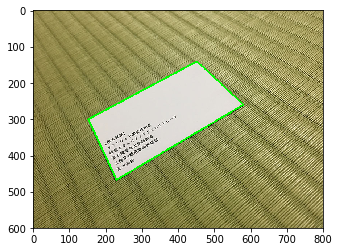

In [21]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 画像読込
img = cv2.imread("Figs/Matched_P.jpg")

# グレイスケール化
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 二値化
ret,th1 = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)

# 輪郭抽出
image, contours, hierarchy = cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 面積の大きいもののみ選別
areas = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 10000:
        epsilon = 0.1*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        areas.append(approx)

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(areas)
cv2.drawContours(img,areas,-1,(0,255,0),3)
plt.imshow(img)
plt.show()

https://qiita.com/mix_dvd/items/5674f26af467098842f0 にしたがったプログラム。
個々で使われている射影変換の関数は http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html#geometric-transformations を参照のこと

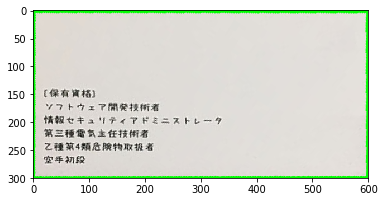

In [22]:
dst = []

pts1 = np.float32(areas[0])
pts2 = np.float32([[600,300],[600,0],[0,0],[0,300]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(600,300))

plt.imshow(dst)
plt.show()


---

## OCR

pyocr というOCRモジュールを使えば、画像から文字を読み取れるそうなので、試してみる

In [23]:
import pyocr
from PIL import Image
tools = pyocr.get_available_tools()
tool = tools[0]
print(tool.image_to_string(Image.fromarray(dst), lang="jpn"))

(保腹資格

ソフトウェヤ開発技条者

情報セキュリティアヤドミニスメトレータ
第三種電気主在技術者

と種策4類拓際物取扱者

空手初段


注意: デフォルトの環境では pyocrとそれを動かす環境ができていないので、以下をみて構築する。
なお、pip install pyocr は成功するが、それだけではダメ(tesseract-ocr tesseract-ocr-jpn* のinstallが必要)
https://github.com/tesseract-ocr/tesseract/wiki

参考: http://73spica.tech/blog/tesseract_for_python/

解像度が低い文字画像だと認識上手くいかない

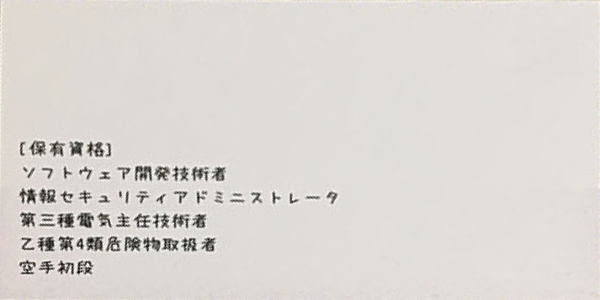

In [19]:
Image.fromarray(dst)

In [ ]:
help(tool)

In [28]:
# 拡大してももとの画像が精度が低ければダメ
import pyocr
from PIL import Image
tools = pyocr.get_available_tools()
tool = tools[0]
size=dst.shape[:2]
im = cv2.resize(dst,(size[1]*2, size[0]*2),cv2.INTER_LANCZOS4)
print(tool.image_to_string(Image.fromarray(dst), lang="jpn"))

(保腹資格

ソフトウェヤ開発技条者

情報セキュリティアヤドミニスメトレータ
第三種電気主在技術者

と種策4類拓際物取扱者

空手初段


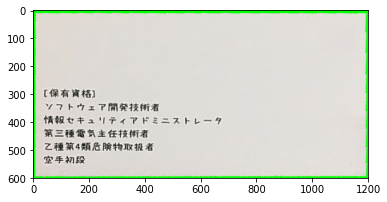

In [27]:
plt.imshow(im)
plt.show()

免許証（ぽいもの）で試す：画像はGoogle検索から拾ったもの

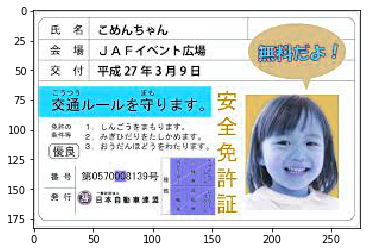

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
img=cv2.imread("Figs/DriversCard2.jpg")
plt.imshow(img)

二値化に工夫が必要でしょう。Otsuか適応的な二値化が必要（免許証の場合背景が色付きですから、それも考慮して)なので、試す

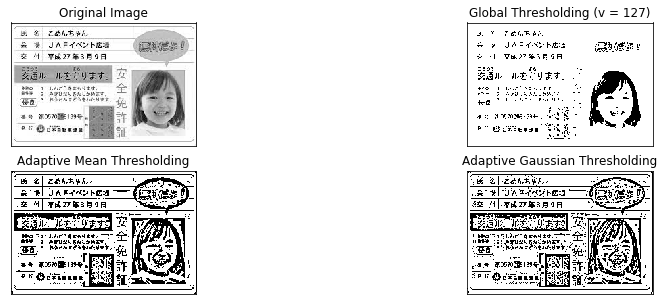

In [73]:
import numpy as np
img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [74]:
for i in range(4):
    print('-'*50)
    print(tool.image_to_string(Image.fromarray(images[i]), lang="jpn"))
print('-'*50)

--------------------------------------------------
馬 名

仁 培 JAFイベント広場

人 平成27年3月9日

00は

まき WOMR9g
の
--------------------------------------------------
てめんちゃん
二 JAFイベント広電
> 1 二葉27生3月9日
--------------------------------------------------
こめんちゃん
AFイベント広場
王婦年3月9
--------------------------------------------------

--------------------------------------------------


どれもダメ。。。（適応的二値化処理ではパラメタ調整が必要）

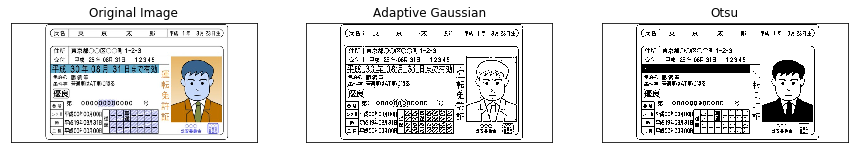

In [79]:
# 少し解像度が良いもので試す: 785X380
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
im=cv2.imread("Figs/DriversCard.jpg")
img = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
img = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
dst = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,3) # パラメタ調整が必要
ret, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # 大津の二値化

plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(im),plt.xticks([]),plt.yticks([]),plt.title('Original Image')
plt.subplot(132),plt.imshow(dst,'gray'), plt.xticks([]),plt.yticks([]),plt.title('Adaptive Gaussian')
plt.subplot(133),plt.imshow(otsu,'gray'),plt.xticks([]),plt.yticks([]),plt.title('Otsu')

plt.show()

In [80]:
import pyocr
from PIL import Image
tools = pyocr.get_available_tools()
tool = tools[0]
print(tool.image_to_string(Image.fromarray(dst), lang="jpn"))

(兵名| 東 京 太 郎 |議 年3月23B生)

 

 

 

[住所 [東京都OO区OG男 1-2-3
交付| 平成25年08朋31日 12345        >     に
平成30 年08月_31.昌まぐ

和許の 明和             連
条件等間はAT還に限る

履周

将号  第
=*由平成00和00有00H
他 |平成9征08H31
ニ|平成00f00B0OH


大津の二値化でも試してみる

In [81]:
import pyocr
from PIL import Image
tools = pyocr.get_available_tools()
tool = tools[0]
print(tool.image_to_string(Image.fromarray(otsu), lang="jpn"))

(氏名| 東 京 本 人郎 |式 1年 3月23Hま)

 

 

 

 

住所 | 系京都OO区〇〇町 1-2-3                             ]
交付 | 平成 25年08朋31日 12345

免許の 服銭等                  Rd
条件等 馬はAT車に限る            転      リ
履財                       免

*引秀 000000900000    LMd/

=平成00W00H00H|       層
他 |平成19f08H31
三成00%00B00H|
